In [ ]:
import pandas as pd
import numpy as np
import re
import time
import os
import itertools
import torch
import ast
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,TensorDataset
from sklearn.model_selection import train_test_split


In [165]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)


Using device: mps


# Static and Dynamic Feature Preparation 
## Static Vector Preparation 

Static vectors were constructed by combining the following features:
- 'town_one_hot', 
- 'flat_type',
- 'street_name_embed',
- 'storey_category', 
- 'floor_area_category', 
- 'flat_model_one_hot', 
- 'lease_commence_date',
- 'hdb_classification_one_hot' 

Each row in the resulting static_vector column represents a unique HDB flat profile, encapsulating the flat’s structural, locational, and classification attributes. These vectors remain constant across time and are used to characterize flats in a way that supports consistent sequence modeling.

In [166]:
file_path5 = "./resale_flat_prices_one_hot_vector_and_embed.xlsx"
df_final = pd.read_excel(file_path5)
df_final.dropna(inplace=True)

In [167]:
# Inspect the data types of each static feature in the dataset
static_features = [
    'town_one_hot', # str
    'flat_type_one_hot', #str
    'street_name_embed', # str
    'storey_category_one_hot', #str
    'floor_area_category', #numpy.int64
    'flat_model_one_hot', #str
    'lease_commence_date',#numpy.float64
    'hdb_classification_one_hot' #str
]
for feature in static_features:
  x=type(df_final.loc[0, feature])
  print(feature,x)


town_one_hot <class 'str'>
flat_type_one_hot <class 'str'>
street_name_embed <class 'str'>
storey_category_one_hot <class 'str'>
floor_area_category <class 'numpy.int64'>
flat_model_one_hot <class 'str'>
lease_commence_date <class 'numpy.float64'>
hdb_classification_one_hot <class 'str'>


In [168]:
# List of columns containing string representations of lists
numeric_columns_to_fix = [
    'town_one_hot',
    'flat_model_one_hot',
    'street_name_embed',
    'storey_category_one_hot',
    'flat_type_one_hot',
    'hdb_classification_one_hot'
]

# Convert each stringified list in the specified columns into an actual Python list
# ast.literal_eval safely parses the string into a list or dict (unlike eval)
for col in numeric_columns_to_fix:
    df_final[col] = df_final[col].apply(ast.literal_eval)


In [169]:
# Sanity check: Count the total number of dimensions across all static features
# This helps verify the expected input size for the feedforward model

counter =0 
for feature in static_features:
    sample = df_final.loc[0, feature]
    
    if isinstance(sample, list):
        length = len(sample)
        counter += length
    else:
        length = 1  # scalar (int, float, one-hot already mapped)
        counter += length
    
    print(f"{feature}: {length} dimensions")
print("Total dimensions for static features:", counter)

town_one_hot: 26 dimensions
flat_type_one_hot: 7 dimensions
street_name_embed: 16 dimensions
storey_category_one_hot: 2 dimensions
floor_area_category: 1 dimensions
flat_model_one_hot: 21 dimensions
lease_commence_date: 1 dimensions
hdb_classification_one_hot: 2 dimensions
Total dimensions for static features: 76


In [170]:
# Function to create a flattened static vector for each flat profile
# Combines all one-hot encoded, embedded, and scalar static features into a single tensor

def flatten_static_features(row):
    return torch.tensor(
        row['town_one_hot'] +
        row['flat_model_one_hot'] +
        row['hdb_classification_one_hot'] +
        row['street_name_embed'] +
        row['flat_type_one_hot'] +
        row['storey_category_one_hot']+
        [
            row['lease_commence_date'],
            row['floor_area_category'],
        ],
        dtype=torch.float32
    )

# Apply the flattening function to every row in the DataFrame
df_final['static_vector'] = df_final.apply(flatten_static_features, axis=1)

# Sanity check: confirm the dimensionality of the resulting static vectors
input_dim = len(df_final.loc[0, 'static_vector'])
print("Feedforward input dim:", input_dim)

# Each row in the 'static_vector' column is now a 76-dimensional torch tensor
df_final['static_vector']


Feedforward input dim: 76


0         [tensor(1.), tensor(0.), tensor(0.), tensor(0....
1         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
2         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
3         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
4         [tensor(0.), tensor(0.), tensor(0.), tensor(0....
                                ...                        
391147    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
391148    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
391149    [tensor(0.), tensor(1.), tensor(0.), tensor(0....
391150    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
391151    [tensor(0.), tensor(0.), tensor(0.), tensor(0....
Name: static_vector, Length: 391152, dtype: object

## Define Train - Test - Val split



In [171]:

''' 
    Split dataset by flat profile. So each group is a flat profile with multiple months of data.
    Then sort each group by month to process the data in true chronological order
    Split each group into train, val, and test sets
    - Train: Before COVID
    - Val: 0-2 year after Singapore's phase 3 lockdown - when most restrictions were lifted
    - Test: After all lockdown measures were lifted
'''

# Ensure 'month' column is datetime
df_final['month'] = pd.to_datetime(df_final['month'])

# Define COVID cutoff points
covid_start = pd.to_datetime("2020-01-01")

# End of Singapore's Phase 3 lockdown - when most restrictions were lifted
val_start = pd.to_datetime("2021-01-01")

# When lockdown measures were lifted
val_cutoff = pd.to_datetime("2023-01-01")   
test_start = pd.to_datetime("2023-01-01")  

# Split globally across all static profiles
df_train = df_final[df_final['month'] < covid_start].reset_index(drop=True)
df_val = df_final[(df_final['month'] >= val_start) & (df_final['month'] < val_cutoff)].reset_index(drop=True)
df_test = df_final[df_final['month'] >= test_start].reset_index(drop=True)

# ✅ Final sanity check
print(f"Train size: {len(df_train)} (Pre-COVID)")
print(f"Validation size: {len(df_val)} (End of Singapore's Phase 3 lockdown)")
print(f"Test size: {len(df_test)} (After all lockdown measures lifted)")


Train size: 129576 (Pre-COVID)
Validation size: 96324 (End of Singapore's Phase 3 lockdown)
Test size: 120588 (After all lockdown measures lifted)


# Filtering Step: Long-Term Static Profiles

Objective:
Retain static profiles (i.e., unique combinations of static features) that have at least 12 consecutive months of historical data.

Why This Matters:
Aggregating diverse rows under the same static profile can lead to short or fragmented time series, which are unsuitable for training sliding window models. By enforcing a minimum sequence length of 12 months, we ensure the model has sufficient historical context for learning meaningful temporal patterns.

In [172]:
def filter_valid_static_profiles(df,df_name, min_months=12, min_streak=12):
    """
    Filters out static profiles with fewer than `min_months = 12` total rows 
    or lacking a contiguous streak of at least `min_streak = 12` months.

    Parameters:
    - df: DataFrame with 'month' and 'static_vector' columns
    - min_months: Minimum total rows per profile (default=12)
    - min_streak: Minimum consecutive monthly streak (default=12)
    - drop_duplicates: Whether to keep only one row per static vector

    Returns:
    - Filtered DataFrame with valid static profiles
    """

    # Step 1: Ensure datetime format and static_tuple column
    df['month'] = pd.to_datetime(df['month'])
    df['static_tuple'] = df['static_vector'].apply(lambda x: tuple(x.tolist()))

    # Step 2: Filter by total months

    # Obtain counts of each static profile
    profile_counts = df['static_tuple'].value_counts()
    # Filter profiles with fewer than min_months
    valid_profiles_by_length = profile_counts[profile_counts > min_months].index
    # Filter the DataFrame to keep only valid profiles
    df = df[df['static_tuple'].isin(valid_profiles_by_length)].copy()

    # Step 3: Filter by contiguous streak
    grouped = df.groupby('static_tuple')
    valid_contiguous_profiles = []

    for static_key, group in grouped:
        # Sort static profile in chronological order
        months = group['month'].sort_values().reset_index(drop=True)

        # Calculate the difference in days between consecutive months
        deltas = months.diff().dropna().dt.days

        streak = 1
        max_streak = 1
        for gap in deltas:
            # If the difference is 31 days or less, it's a contiguous month
            if gap <= 31:  
                streak += 1
                max_streak = max(max_streak, streak)
            else:
                # Reset streak if gap is larger than 31 days
                streak = 1

        if max_streak >= min_streak:
            valid_contiguous_profiles.append(static_key)

    df = df[df['static_tuple'].isin(valid_contiguous_profiles)].copy()

    

    # Step 5: Logging
    print(f"Dataset: named {df_name}")
    print(f"Filtered dataset size: {len(df)}")

    return df


df_train = filter_valid_static_profiles(df_train,"train")
df_val   = filter_valid_static_profiles(df_val,"val")
df_test  = filter_valid_static_profiles(df_test,"test")



Dataset: named train
Filtered dataset size: 84338
Dataset: named val
Filtered dataset size: 51944
Dataset: named test
Filtered dataset size: 79060


In [173]:
df_train.head()


,month,town,flat_type,street_name,storey_category,floor_area_category,flat_model,lease_commence_date,remaining_lease,resale_price,hdb_classification,town_one_hot,flat_type_one_hot,storey_category_one_hot,flat_model_one_hot,hdb_classification_one_hot,street_name_idx,street_name_embed,static_vector,static_tuple
0,2017-01-01,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,Low,40,Improved,1979.0,61.333333,232000.0,Mature,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0]","[0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0]",0,"[-0.9256269335746765, -0.9982683062553406, 0.4...","[tensor(1.), tensor(0.), tensor(0.), tensor(0....","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2017-01-01,JURONG EAST,EXECUTIVE,JURONG EAST ST 21,Low,170,Apartment,1993.0,75.000000,720000.0,Non-Mature,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0]","[0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1]",1,"[-0.8508911728858948, -0.9962965846061707, 0.5...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2017-01-01,JURONG EAST,EXECUTIVE,JURONG EAST ST 31,Low,140,Apartment,1985.0,66.916667,625000.0,Non-Mature,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0]","[0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1]",2,"[-0.9962167143821716, -0.9977923631668091, -0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2017-01-01,JURONG EAST,EXECUTIVE,JURONG EAST ST 31,Low,145,Maisonette,1985.0,66.833333,692500.0,Non-Mature,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0]","[0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1]",2,"[-0.9962167143821716, -0.9977923631668091, -0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2017-01-01,JURONG EAST,EXECUTIVE,TOH GUAN RD,Low,145,Maisonette,1998.0,80.333333,792000.0,Non-Mature,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0]","[0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1]",3,"[-0.8723868131637573, -0.9739601016044617, 0.7...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Normalize Non-static features

Price and Remaining Lease

In [174]:
def normalize_price_and_lease(df):
    """
    Normalizes 'resale_price' and 'remaining_lease' columns using mean and std from training set.

    Parameters:
    - df : DataFrame containing 'resale_price' and 'remaining_lease' columns

    Returns:
    - DataFrame with normalized columns
    """

    # Compute normalization stats from training set
    resale_mean = df['resale_price'].mean()
    resale_std = df['resale_price'].std()
    lease_mean = df['remaining_lease'].mean()
    lease_std = df['remaining_lease'].std()


    df['resale_price_normalized'] = (df['resale_price'] - resale_mean) / resale_std
    df['remaining_lease_normalized'] = (df['remaining_lease'] - lease_mean) / lease_std
    

    return  df
df_final = normalize_price_and_lease(df_final)
df_train = normalize_price_and_lease(df_train)
df_val = normalize_price_and_lease(df_val)
df_test = normalize_price_and_lease(df_test)


In [175]:
# Sanity check
df_train['resale_price_normalized']

0        -1.483587
1         1.283756
2         0.745032
3         1.127810
4         1.692053
            ...   
129571   -1.273768
129572   -1.401361
129573   -1.239743
129574   -1.171694
129575   -1.330476
Name: resale_price_normalized, Length: 84338, dtype: float64

## Create Feedforward layer using static vectors

In [176]:

# Define the feedforward model
class StaticFFModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(input_dim, 128), # Hyperparameter
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.ff(x)

# Create instance
static_ff = StaticFFModel(input_dim=76, output_dim=76) # Note we should modify the output dimension to fit the hidden layer of the LSTM model. 

# Move model to MPS (or CUDA/CPU depending on your setup)
static_ff = static_ff.to(device)

#processing df_train
static_tensor_batch = torch.stack(df_train['static_vector'].tolist()).to(device)  
feedforward_output_train = static_ff(static_tensor_batch)
df_train['static_embedding'] = feedforward_output_train.detach().cpu().tolist()

#processing df_val
static_tensor_batch = torch.stack(df_val['static_vector'].tolist()).to(device)
feedforward_output_val = static_ff(static_tensor_batch)
df_val['static_embedding'] = feedforward_output_val.detach().cpu().tolist()

#processing df_test
static_tensor_batch = torch.stack(df_test['static_vector'].tolist()).to(device)
feedforward_output_test = static_ff(static_tensor_batch)
df_test['static_embedding'] = feedforward_output_test.detach().cpu().tolist()

print ("Train set with static embedding shape:", df_train['static_embedding'].apply(lambda x: len(x)).unique())
print ("Val set with static embedding shape:", df_val['static_embedding'].apply(lambda x: len(x)).unique())
print ("Test set with static embedding shape:", df_test['static_embedding'].apply(lambda x: len(x)).unique())



Train set with static embedding shape: [76]
Val set with static embedding shape: [76]
Test set with static embedding shape: [76]


# Sliding Window

In [177]:
def generate_sequences(df, window_size=12):
    x_combined_list = []
    y_list = []

    grouped = df.groupby("static_tuple")

    for _, group in grouped:
        group = group.sort_values("month").reset_index(drop=True)

        if len(group) < window_size + 1:
            continue  # not enough data to create a window
        

        for i in range(len(group) - window_size):
            # Select 12 rows of data at row i, with 2 columns: resale_price and remaining_lease
            # x_window.shape = [12, 2]
            x_window = group.loc[i:i+window_size-1, ["resale_price_normalized", "remaining_lease_normalized"]].values
            
        
            # Obtain static embedding at time t+1
            # repeat for 12 time steps
            x_static = group.loc[i+window_size, "static_embedding"]
            x_static_repeated = np.tile(x_static, (window_size, 1))  
            
            # Concatenate dynamic and static features 
            x_combined = np.concatenate([x_window, x_static_repeated], axis=1)

            # Target: resale_price at time t+1
            y = group.loc[i+window_size, "resale_price_normalized"]

            x_combined_list.append(x_combined) # Store input 
            y_list.append(y) #Store output

    # Convert to tensors
    X_tensor = torch.tensor(np.array(x_combined_list), dtype=torch.float32)  # [N, 12, 76]
    y_tensor = torch.tensor(np.array(y_list), dtype=torch.float32)           # [N]

    return X_tensor, y_tensor


In [178]:
X_train, y_train = generate_sequences(df_train)
X_val, y_val = generate_sequences(df_val)
X_test, y_test = generate_sequences(df_test)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: torch.Size([49862, 12, 78]) torch.Size([49862])
Val shape: torch.Size([24728, 12, 78]) torch.Size([24728])
Test shape: torch.Size([43492, 12, 78]) torch.Size([43492])


In [179]:
def get_tensor_loader(X_tensor, y_tensor, batch_size=32, shuffle=True):
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [180]:
train_loader = get_tensor_loader(X_train, y_train, batch_size=32, shuffle=True)
val_loader = get_tensor_loader(X_val, y_val, batch_size=32, shuffle=False)
test_loader = get_tensor_loader(X_test, y_test, batch_size=32, shuffle=False)


# LSTM

### LSTM2LSTM Saver and Loader Functions

In [181]:


def save_lstm2lstm_model(model, optimizer, epoch, loss, filename="lstm2lstm_best.pt"):
    """
    Saves model and optimizer state into ./checkpoints directory.
    """
    checkpoint_dir = os.path.join('.', 'checkpoints')
    os.makedirs(checkpoint_dir, exist_ok=True)

    save_path = os.path.join(checkpoint_dir, filename)

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }, save_path)

    print(f"✅ Model checkpoint saved to: {save_path}")

def load_lstm2lstm_model(model, optimizer, filename="lstm2lstm_best.pt", device="cpu"):
    checkpoint_path = os.path.join('.', 'checkpoints', filename)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    print(f"📂 Loaded model from {checkpoint_path} (Epoch {epoch}, Val Loss: {loss:.4f})")
    return model, optimizer, epoch, loss



### LSTM2LSTM Encoder and Decoder

In [ ]:
class LSTMEncoder(nn.Module):
    def __init__(self, non_static_dim, static_embedding_dim, hidden_dim, num_layers=1):
        super().__init__()
        input_dim = non_static_dim + static_embedding_dim
        self.lstm = nn.LSTM(
            input_size=input_dim, # 2 +76 (dynamic + static) = 78 
            hidden_size=hidden_dim, # Hyperparameter
            num_layers=num_layers, # Hyperparameter
            batch_first=True # input tensor (x) shape is set to [batch_size, sequence_length, input_dim]
        )

    def forward(self, x): 
        # x shape: [batch_size, sequence_length, input_dim]
        # out is the hidden state for all time steps
        # hidden = (hn, cn),
        # hn -  hidden state for the last time step 
        # cn - long term history
        out, hidden = self.lstm(x)
        return hidden  # Return full hidden & cell states
    


In [183]:
class LSTMDecoder(nn.Module):
    def __init__(self, hidden_dim, static_embedding_dim, output_dim=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = output_dim + static_embedding_dim  # 1 + 76
        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_encoder, target_len, static_embed, hidden, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):
        """
        Inputs:
        - target_len: length of the target sequence:, how many resale prices to predict ? 
        - static_embed: [B, 64] - static embedding repeated for each time step 
        - hidden = (hn, cn): states from encoder
        - teacher_forcing_inputs: [B, target_len] optional ground truth inputs values 
        - teacher_forcing_ratio: how often to use ground truth vs predicted values 
        Returns:
        - outputs: [B, target_len]
        """
        batch_size = static_embed.size(0) # Batch size 
        output_dim = self.fc.out_features # 1 
        outputs = []

        # Initialize the input step with the last time step of the encoder input
        input_step = x_encoder[:, -1, 0].unsqueeze(1).unsqueeze(2).to(static_embed.device) 

        # Run the decoder target_len times 
        # If we want a prediction 5 years ahead, target_len = 60
        for t in range(target_len):
            # Concatenate static embedding to every input
            static_t = static_embed.unsqueeze(1)  # [B, 1, 76]
            lstm_input = torch.cat([input_step, static_t], dim=2)  # [B, 1, 1+76]

            out, hidden = self.lstm(lstm_input, hidden)  # out: [B, 1, H]
            output = self.fc(out)  # [B, 1, 1]
            outputs.append(output.squeeze(1))  # [B, 1] → squeeze time dim

            # Decide whether to use teacher forcing
            # When training, we can use teacher forcing to improve convergence
            # When doing inference into the future, we use the predicted value
            if teacher_forcing_inputs is not None and torch.rand(1).item() < teacher_forcing_ratio:
                input_step = teacher_forcing_inputs[:, t].unsqueeze(1).unsqueeze(-1)  # [B, 1, 1]
            else:
                input_step = output  # Autoregressive prediction 

        return torch.cat(outputs, dim=1)  # [B, target_len]


In [ ]:
class Seq2SeqModel(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x, static_embed, target_len=1, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):
        hidden = self.encoder(x)
        return self.decoder(
            x_encoder=x,
            target_len=target_len,
            static_embed=static_embed,
            hidden=hidden,
            teacher_forcing_inputs=teacher_forcing_inputs,
            teacher_forcing_ratio=teacher_forcing_ratio
        )

def train_epoch(model, dataloader, optimizer, criterion, device, target_len=1, teacher_forcing=True):
    model.train()
    total_loss = 0

    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)             
        y_batch = y_batch.to(device)          

        static_embed = x_batch[:, 0, -76:]        # extract static embedding (same across all time steps)

        # If teacher forcing, use the ground truth values for the next time step 
        # Else use the predicted values
        teacher_inputs = y_batch.unsqueeze(1) if teacher_forcing else None  

        optimizer.zero_grad()
        outputs = model(
            x_batch,
            static_embed,
            target_len=target_len,
            teacher_forcing_inputs=teacher_inputs,
            teacher_forcing_ratio=0.5 if teacher_forcing else 0.0 # Hyperparameter
        )

        # If multi-step: criterion on all time steps; if single-step: squeeze
        if target_len == 1:
            outputs = outputs.squeeze(1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)




In [185]:
def validate_epoch(model, dataloader, criterion, device, resale_mean, resale_std, target_len=1):
    model.eval()
    total_loss = 0
    preds = []
    trues = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            static_embed = x_batch[:, 0, -76:]

            outputs = model(
                x_batch,
                static_embed,
                target_len=target_len,
                teacher_forcing_inputs=None,
                teacher_forcing_ratio=0.0
            )

            if target_len == 1:
                outputs = outputs.squeeze(1)

            loss = criterion(outputs, y_batch)
            total_loss += loss.item()

            preds.append(outputs.cpu())
            trues.append(y_batch.cpu())

    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()

    # Denormalize
    preds_denorm = preds * resale_std + resale_mean
    trues_denorm = trues * resale_std + resale_mean

    # Compute metrics
    mae = np.mean(np.abs(trues_denorm - preds_denorm))
    ss_res = np.sum((trues_denorm - preds_denorm) ** 2)
    ss_tot = np.sum((trues_denorm - np.mean(trues_denorm)) ** 2)
    r2 = 1 - ss_res / ss_tot

    return total_loss / len(dataloader), mae, r2, preds_denorm, trues_denorm


In [186]:
def plot_predictions(true_values, predicted_values, title="Validation Predictions"):
    plt.figure(figsize=(6, 6))
    plt.scatter(true_values, predicted_values, alpha=0.3)
    plt.plot([true_values.min(), true_values.max()],
             [true_values.min(), true_values.max()], 'r--')
    plt.xlabel("True Resale Price")
    plt.ylabel("Predicted Resale Price")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [187]:
df_train.head()

,month,town,flat_type,street_name,storey_category,floor_area_category,flat_model,lease_commence_date,remaining_lease,resale_price,...,storey_category_one_hot,flat_model_one_hot,hdb_classification_one_hot,street_name_idx,street_name_embed,static_vector,static_tuple,resale_price_normalized,remaining_lease_normalized,static_embedding
0,2017-01-01,ANG MO KIO,2 ROOM,ANG MO KIO AVE 10,Low,40,Improved,1979.0,61.333333,232000.0,...,"[0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0]",0,"[-0.9256269335746765, -0.9982683062553406, 0.4...","[tensor(1.), tensor(0.), tensor(0.), tensor(0....","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",-1.483587,-0.972544,"[6.336752891540527, 0.0, 0.0, 109.633979797363..."
1,2017-01-01,JURONG EAST,EXECUTIVE,JURONG EAST ST 21,Low,170,Apartment,1993.0,75.000000,720000.0,...,"[0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1]",1,"[-0.8508911728858948, -0.9962965846061707, 0.5...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.283756,0.200494,"[7.008711338043213, 0.0, 0.0, 113.585159301757..."
2,2017-01-01,JURONG EAST,EXECUTIVE,JURONG EAST ST 31,Low,140,Apartment,1985.0,66.916667,625000.0,...,"[0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1]",2,"[-0.9962167143821716, -0.9977923631668091, -0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.745032,-0.493315,"[6.9219136238098145, 0.0, 0.0, 112.54044342041..."
3,2017-01-01,JURONG EAST,EXECUTIVE,JURONG EAST ST 31,Low,145,Maisonette,1985.0,66.833333,692500.0,...,"[0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1]",2,"[-0.9962167143821716, -0.9977923631668091, -0....","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.127810,-0.500468,"[6.971571922302246, 0.0, 0.0, 112.682495117187..."
4,2017-01-01,JURONG EAST,EXECUTIVE,TOH GUAN RD,Low,145,Maisonette,1998.0,80.333333,792000.0,...,"[0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1]",3,"[-0.8723868131637573, -0.9739601016044617, 0.7...","[tensor(0.), tensor(0.), tensor(0.), tensor(0....","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.692053,0.658265,"[6.907724380493164, 0.0, 0.0, 113.362403869628..."


### LSTM2LSTM Training

Epoch 1 | Train Loss: 0.1949 | Val Loss: 0.2040 | MAE: 78470.68 | R²: 0.81
✅ Model checkpoint saved to: ./checkpoints/lstm2lstm_best.pt
Best model updated
Epoch 2 | Train Loss: 0.0342 | Val Loss: 0.0369 | MAE: 24602.46 | R²: 0.96
✅ Model checkpoint saved to: ./checkpoints/lstm2lstm_best.pt
Best model updated
Epoch 3 | Train Loss: 0.0358 | Val Loss: 0.1300 | MAE: 56712.74 | R²: 0.88
Epoch 4 | Train Loss: 0.0443 | Val Loss: 0.0340 | MAE: 21019.49 | R²: 0.97
✅ Model checkpoint saved to: ./checkpoints/lstm2lstm_best.pt
Best model updated
Epoch 5 | Train Loss: 0.0322 | Val Loss: 0.0298 | MAE: 20007.24 | R²: 0.97
✅ Model checkpoint saved to: ./checkpoints/lstm2lstm_best.pt
Best model updated
Epoch 6 | Train Loss: 0.0299 | Val Loss: 0.0738 | MAE: 42750.20 | R²: 0.93
Epoch 7 | Train Loss: 0.0290 | Val Loss: 0.0360 | MAE: 25900.39 | R²: 0.97
Epoch 8 | Train Loss: 0.0297 | Val Loss: 0.0376 | MAE: 27892.32 | R²: 0.96
Epoch 9 | Train Loss: 0.0291 | Val Loss: 0.0448 | MAE: 29007.78 | R²: 0.96
Epoch

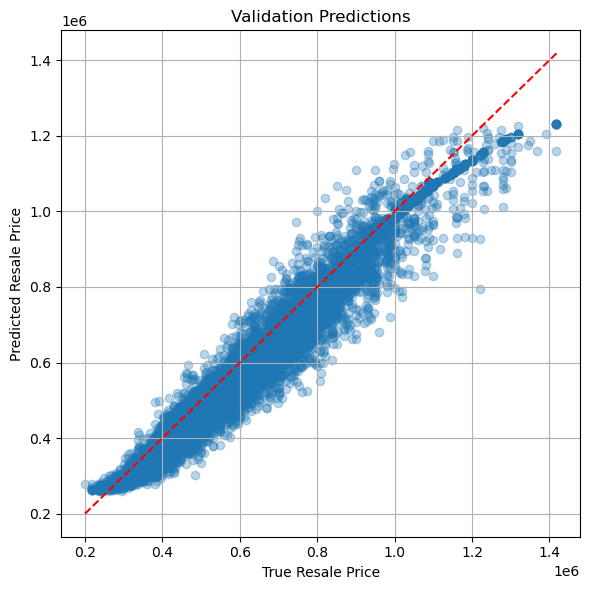

In [ ]:
non_static_dim = 2         # resale_price_normalized + remaining_lease_normalized
static_embedding_dim = 76  # output of your StaticFFModel
hidden_dim = 76            # tunable

encoder = LSTMEncoder(
    non_static_dim=non_static_dim,
    static_embedding_dim=static_embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=1
).to(device)

decoder = LSTMDecoder(
    hidden_dim=hidden_dim,
    static_embedding_dim=static_embedding_dim,
    output_dim=1
).to(device)

model = Seq2SeqModel(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


# For saving the best model
best_val_loss = float('inf')

# Timer 
total_start_time = time.time() 

# Training loop
for epoch in range(10):

    epoch_start_time = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, target_len=1)

    # Compute validation-specific normalization stats
    val_resale_mean = df_val['resale_price'].mean()
    val_resale_std = df_val['resale_price'].std()

    val_loss, val_mae, val_r2, val_preds, val_trues = validate_epoch(
        model, val_loader, criterion, device,
        resale_mean=val_resale_mean, resale_std=val_resale_std,
        target_len=1
    )

    epoch_end_time = time.time()  # End timing
    epoch_time = epoch_end_time - epoch_start_time

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | R²: {val_r2:.2f} | Time: {epoch_time:.2f}s")
    
    # Save only if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_lstm2lstm_model(model, optimizer, epoch=epoch+1, loss=val_loss, filename="lstm2lstm_best.pt")
        print("Best model updated")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

plot_predictions(val_trues, val_preds)


### Load best model parameters and evaluate on Test Set  (LSTM2LSTM)

📂 Loaded model from ./checkpoints/lstm2lstm_best.pt (Epoch 5, Val Loss: 0.0298)


/var/folders/5x/zyxhwl456zgdlj_lrsfyy9qm0000gn/T/ipykernel_69732/3483268832.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map


📊 Test Results — MAE: 18547.87, R²: 0.98, Loss: 0.0215


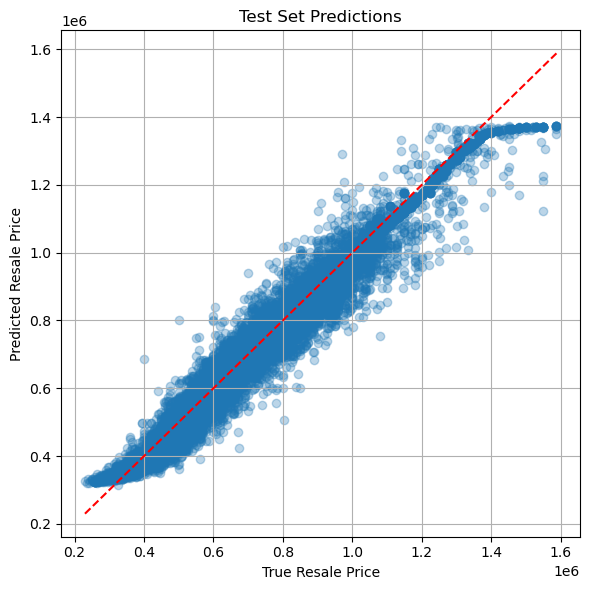

In [189]:
# Load the best model after training
model, optimizer, best_epoch, best_loss = load_lstm2lstm_model(
    model, optimizer, filename="lstm2lstm_best.pt", device=device
)

# Compute test-specific normalization stats
test_resale_mean = df_test['resale_price'].mean()
test_resale_std = df_test['resale_price'].std()

# Run evaluation on the test set
test_loss, test_mae, test_r2, test_preds, test_trues = validate_epoch(
    model, test_loader, criterion, device,
    resale_mean=test_resale_mean,
    resale_std=test_resale_std,
    target_len=1
)

# Print performance metrics
print(f"\n📊 Test Results — MAE: {test_mae:.2f}, R²: {test_r2:.2f}, Loss: {test_loss:.4f}")

# Plot predictions vs ground truth
plot_predictions(test_trues, test_preds, title="Test Set Predictions")


### LSTM2LSTM HDB resale flat price prediction

In [190]:
def build_static_embedding(row):
    return np.concatenate([
        np.array(row['town_one_hot']),
        np.array(row['flat_type_one_hot']),
        np.array(row['storey_category_one_hot']),
        np.array(row['flat_model_one_hot']),
        np.array(row['hdb_classification_one_hot']),
        np.array(row['street_name_embed']),
        np.array([row['lease_commence_date'] / 2025.0]),         # normalize year
        np.array([row['floor_area_category'] / 200.0])           # normalize area
    ])

df_final["static_embedding"] = df_final.apply(build_static_embedding, axis=1)

In [191]:
def recommend_profitable_flats(town, budget, purchase_year, forecast_years, df, model, device):
    model.eval()
    purchase_cutoff = pd.to_datetime(f"{purchase_year}-12-31")
    df_filtered = df[(df['town'] == town) & (df['month'] <= purchase_cutoff) & (df['resale_price'] <= budget)]
  

    df_filtered.columns.tolist()
    results = []
    with torch.no_grad():

        # Compute mean and std specific to the filtered data
        resale_mean_local = df_filtered['resale_price'].mean()
        resale_std_local = df_filtered['resale_price'].std()

        df_filtered = df_filtered.copy()  # avoid SettingWithCopyWarning
        df_filtered['static_tuple'] = df_filtered['static_embedding'].apply(lambda x: tuple(x))

      

        for key, group in df_filtered.groupby("static_tuple"):
            group = group.sort_values("month").reset_index(drop=True)

            if len(group) < 12:
                continue  # skip if not enough months for sliding window

            # Simulate 12-month time window from most recent data before purchase_year
            x_window = group.iloc[-12:][["resale_price_normalized", "remaining_lease_normalized"]].values  # [12, 2]
            static_embed = group.iloc[-1]["static_embedding"]  # 
            x_static_repeated = np.tile(static_embed, (12, 1))  # 
            x_combined = np.concatenate([x_window, x_static_repeated], axis=1)  # 

            x_tensor = torch.tensor(x_combined, dtype=torch.float32).unsqueeze(0).to(device)  # [1, 12, 66]
            static_tensor = torch.tensor(static_embed, dtype=torch.float32).unsqueeze(0).to(device)  # [1, 64]

            # Forecast resale prices
            forecast_len = max(forecast_years)
            forecast = model(x_tensor, static_tensor, target_len=forecast_len, teacher_forcing_inputs=None, teacher_forcing_ratio=0.0)
            forecast = forecast.squeeze(0).cpu().numpy()  # [forecast_len]

            # Denormalize predictions
            forecast_denorm = forecast * resale_std_local + resale_mean_local

            for year in forecast_years:
                future_price = forecast_denorm[year - 1]
                buy_price = group.iloc[-1]["resale_price"]
                profit = future_price - buy_price
                results.append({
                    "street_name": group.iloc[-1]["street_name"] if "street_name" in group.columns else str(key),
                    "flat_type": group.iloc[-1]["flat_type"] if "flat_type" in group.columns else "Unknown",
                    "purchase_price": buy_price,
                    "year": purchase_year + year,
                    "predicted_price": future_price,
                    "estimated_profit": profit
                })

    # Sort by highest average profit per street
    result_df = pd.DataFrame(results)
    top_streets = result_df.groupby("street_name")["estimated_profit"].mean().sort_values(ascending=False).head(10)

    
    print("\n🏆 Top 10 Profitable Streets:")
    print(top_streets)
 
    return result_df, top_streets


In [192]:
results_df_lstm, top_streets_lstm = recommend_profitable_flats(
    town="TAMPINES",
    budget=500000,
    purchase_year=2017,
    forecast_years=[5, 6, 7],
    df=df_final,
    model=model,
    device=device
)



🏆 Top 10 Profitable Streets:
street_name
TAMPINES ST 24    140886.958333
TAMPINES ST 42     87687.288194
TAMPINES AVE 4     73813.214583
TAMPINES AVE 8     65466.583333
TAMPINES ST 41     59923.284722
TAMPINES ST 44     56395.564236
TAMPINES ST 12     37587.680556
TAMPINES ST 21     30884.506250
TAMPINES ST 11     29960.604167
SIMEI ST 1         26851.838542
Name: estimated_profit, dtype: float64


# GRU

### GRU2GRU Saver and Loader Functions

In [193]:
def save_gru2gru_model(model, optimizer, epoch, loss, filename="gru2gru_best.pt"):
    """
    Saves model and optimizer state into ./checkpoints directory.
    """
    checkpoint_dir = os.path.join('.', 'checkpoints')
    os.makedirs(checkpoint_dir, exist_ok=True)

    save_path = os.path.join(checkpoint_dir, filename)

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }, save_path)

    print(f"✅ Model checkpoint saved to: {save_path}")

def load_gru2gru_model(model, optimizer, filename="gru2gru_best.pt", device="cpu"):
    checkpoint_path = os.path.join('.', 'checkpoints', filename)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    print(f"📂 Loaded model from {checkpoint_path} (Epoch {epoch}, Val Loss: {loss:.4f})")
    return model, optimizer, epoch, loss


### GRU2GRU Encoder and Decoder

In [194]:
class GRUEncoder(nn.Module):
    def __init__(self, non_static_dim, static_embedding_dim, hidden_dim, num_layers=1):
        super().__init__()
        input_dim = non_static_dim + static_embedding_dim
        self.gru = nn.GRU(
            input_size=input_dim, # 2 +76 (dynamic + static) = 78 
            hidden_size=hidden_dim, # Hyperparameter
            num_layers=num_layers, # Hyperparameter
            batch_first=True # input tensor (x) shape is set to [batch_size, sequence_length, input_dim]
        )

    def forward(self, x):
        # x shape: [batch_size, sequence_length, input_dim]
        # out is the hidden state for all time steps
        # hidden = hidden state for the last time step
        out, hidden = self.gru(x)
        return hidden  # Return full hidden & cell states

In [195]:
class GRUDecoder(nn.Module):
    def __init__(self, hidden_dim, static_embedding_dim, output_dim=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = output_dim + static_embedding_dim  # 1 + 76
        self.gru = nn.GRU(input_size=self.input_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_encoder, target_len, static_embed, hidden, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):
        """
        Inputs:
        - target_len: length of the target sequence:, how many resale prices to predict ? 
        - static_embed: [B, 64] - static embedding repeated for each time step 
        - hidden: state from encoder
        - teacher_forcing_inputs: [B, target_len] optional ground truth inputs values 
        - teacher_forcing_ratio: how often to use ground truth vs predicted values 
        Returns:
        - outputs: [B, target_len]
        """

        outputs = []
        # Initialize the input step with the last time step of the encoder input
        input_step = x_encoder[:, -1, 0].unsqueeze(1).unsqueeze(2).to(static_embed.device) 

        # Run the decoder target_len times 
        # If we want a prediction 5 years ahead, target_len = 60
        for t in range(target_len):
            # Concatenate static embedding to every input
            static_t = static_embed.unsqueeze(1)  # [B, 1, 76]
            lstm_input = torch.cat([input_step, static_t], dim=2)  # [B, 1, 1+76]

            out, hidden = self.gru(lstm_input, hidden)  # out: [B, 1, H]
            output = self.fc(out)  # [B, 1, 1]
            outputs.append(output.squeeze(1))  # [B, 1] → squeeze time dim

            # Decide whether to use teacher forcing
            # When training, we can use teacher forcing to improve convergence
            # When doing inference into the future, we use the predicted value
            if teacher_forcing_inputs is not None and torch.rand(1).item() < teacher_forcing_ratio:
                input_step = teacher_forcing_inputs[:, t].unsqueeze(1).unsqueeze(-1)  # [B, 1, 1]
            else:
                input_step = output  # Autoregressive prediction 

        return torch.cat(outputs, dim=1)  # [B, target_len]

### GRU2GRU Training

Epoch 1 | Train Loss: 0.2024 | Val Loss: 0.0729 | MAE: 43304.71 | R²: 0.93
✅ Model checkpoint saved to: ./checkpoints/gru2gru_best.pt
Best model updated
Epoch 2 | Train Loss: 0.0344 | Val Loss: 0.0804 | MAE: 46077.66 | R²: 0.92
Epoch 3 | Train Loss: 0.0337 | Val Loss: 0.1258 | MAE: 58229.93 | R²: 0.88
Epoch 4 | Train Loss: 0.0313 | Val Loss: 0.0286 | MAE: 19976.26 | R²: 0.97
✅ Model checkpoint saved to: ./checkpoints/gru2gru_best.pt
Best model updated
Epoch 5 | Train Loss: 0.0298 | Val Loss: 0.0829 | MAE: 38661.94 | R²: 0.92
Epoch 6 | Train Loss: 0.0304 | Val Loss: 0.0510 | MAE: 30724.99 | R²: 0.95
Epoch 7 | Train Loss: 0.0291 | Val Loss: 0.0361 | MAE: 25656.52 | R²: 0.97
Epoch 8 | Train Loss: 0.0280 | Val Loss: 0.0300 | MAE: 20371.44 | R²: 0.97
Epoch 9 | Train Loss: 0.0278 | Val Loss: 0.0354 | MAE: 22674.96 | R²: 0.97
Epoch 10 | Train Loss: 0.0269 | Val Loss: 0.0314 | MAE: 22030.10 | R²: 0.97


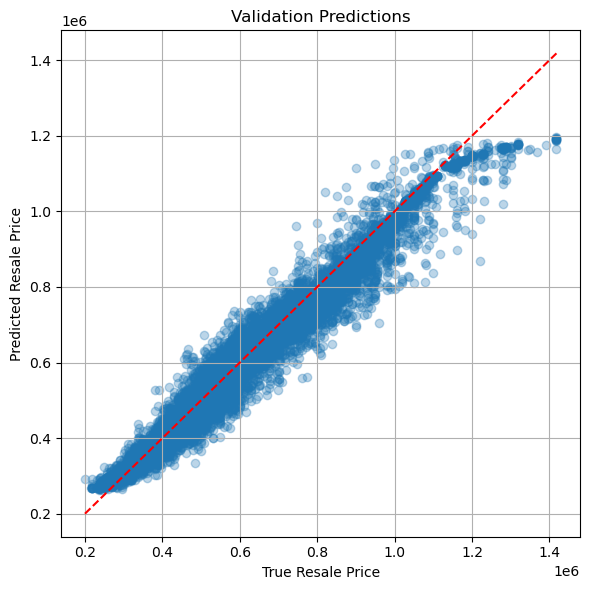

In [ ]:
non_static_dim = 2         # resale_price_normalized + remaining_lease_normalized
static_embedding_dim = 76  # output of your StaticFFModel
hidden_dim = 76            # tunable

encoder = GRUEncoder(
    non_static_dim=non_static_dim,
    static_embedding_dim=static_embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=1
).to(device)

decoder = GRUDecoder(
    hidden_dim=hidden_dim,
    static_embedding_dim=static_embedding_dim,
    output_dim=1
).to(device)

model = Seq2SeqModel(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


best_val_loss = float('inf')


# Timer 
total_start_time = time.time() 

# Training loop
for epoch in range(10):

    epoch_start_time = time.time()

    
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, target_len=1)

    # Compute validation-specific normalization stats
    val_resale_mean = df_val['resale_price'].mean()
    val_resale_std = df_val['resale_price'].std()

    val_loss, val_mae, val_r2, val_preds, val_trues = validate_epoch(
        model, val_loader, criterion, device,
        resale_mean=val_resale_mean, resale_std=val_resale_std,
        target_len=1
    )



    epoch_end_time = time.time()  # End timing
    epoch_time = epoch_end_time - epoch_start_time

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | R²: {val_r2:.2f} | Time: {epoch_time:.2f}s")
    


    # Save only if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_gru2gru_model(model, optimizer, epoch=epoch+1, loss=val_loss, filename="gru2gru_best.pt")
        print("Best model updated")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

plot_predictions(val_trues, val_preds)

### Load best model parameters and evaluate on Test Set (GRU2GRU)

📂 Loaded model from ./checkpoints/gru2gru_best.pt (Epoch 4, Val Loss: 0.0286)


/var/folders/5x/zyxhwl456zgdlj_lrsfyy9qm0000gn/T/ipykernel_69732/1552801373.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map


📊 Test Results — MAE: 19040.36, R²: 0.98, Loss: 0.0213


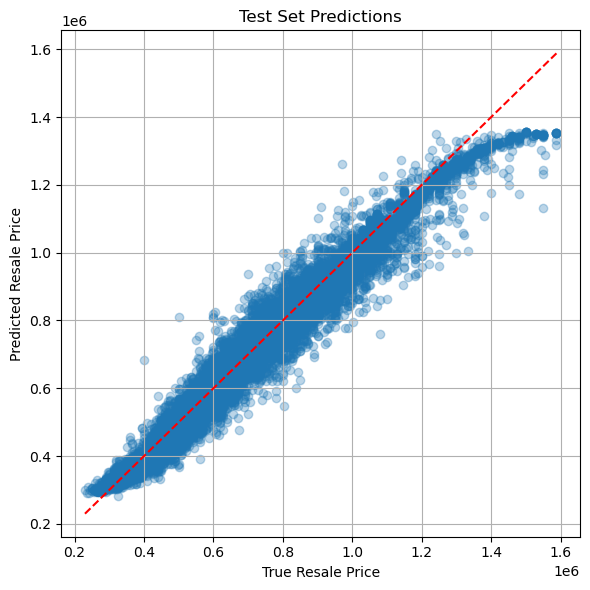

In [197]:
### Load best model parameters and evaluate on Test Set 
# Load the best model after training
model, optimizer, best_epoch, best_loss = load_gru2gru_model(
    model, optimizer, filename="gru2gru_best.pt", device=device
)

# Compute test-specific normalization stats
test_resale_mean = df_test['resale_price'].mean()
test_resale_std = df_test['resale_price'].std()

# Run evaluation on the test set
test_loss, test_mae, test_r2, test_preds, test_trues = validate_epoch(
    model, test_loader, criterion, device,
    resale_mean=test_resale_mean,
    resale_std=test_resale_std,
    target_len=1
)

# Print performance metrics
print(f"\n📊 Test Results — MAE: {test_mae:.2f}, R²: {test_r2:.2f}, Loss: {test_loss:.4f}")

# Plot predictions vs ground truth
plot_predictions(test_trues, test_preds, title="Test Set Predictions")


### GRU2GRU HDB resale flat price prediction

In [198]:
results_df_gru, top_streets_gru = recommend_profitable_flats(
    town="TAMPINES",
    budget=500000,
    purchase_year=2017,
    forecast_years=[5, 6, 7],
    df=df_final,
    model=model,
    device=device,
)



🏆 Top 10 Profitable Streets:
street_name
TAMPINES ST 24    -6261.635417
TAMPINES AVE 8    -8783.927083
TAMPINES ST 41   -45827.506944
TAMPINES AVE 4   -45980.793750
TAMPINES ST 11   -58632.567708
TAMPINES AVE 9   -65079.075521
TAMPINES ST 42   -68755.493056
TAMPINES ST 84   -69401.385417
TAMPINES ST 44   -81448.552083
TAMPINES ST 21   -82399.256250
Name: estimated_profit, dtype: float64


# GRU-to-LSTM

### GRU2LSTM Saver and Loader Functions

In [ ]:


def save_gru2lstm_model(model, optimizer, epoch, loss, filename="gru2lstm_best.pt"):
    """
    Saves model and optimizer state into ./checkpoints directory.
    """
    checkpoint_dir = os.path.join('.', 'checkpoints')
    os.makedirs(checkpoint_dir, exist_ok=True)

    save_path = os.path.join(checkpoint_dir, filename)

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }, save_path)

    print(f"Model checkpoint saved to: {save_path}")

def load_gru2lstm_model(model, optimizer, filename="gru2lstm_best.pt", device="cpu"):
    checkpoint_path = os.path.join('.', 'checkpoints', filename)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    print(f"📂 Loaded model from {checkpoint_path} (Epoch {epoch}, Val Loss: {loss:.4f})")
    return model, optimizer, epoch, loss

### GRU2LSTM Encoder and decoder

In [200]:
class GRUtoLSTM(nn.Module):
    def __init__(self, encoder: GRUEncoder, decoder: LSTMDecoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, static_embed, target_len=1, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):

        hidden = self.encoder(x) # Obtain hidden and cell states from encoder
        return self.decoder(
            x_encoder=x,
            target_len=target_len,
            static_embed=static_embed,
            hidden=(hidden, hidden),
            teacher_forcing_inputs=teacher_forcing_inputs,
            teacher_forcing_ratio=teacher_forcing_ratio
        )

### GRU2LSTM Training

Epoch 1 | Train Loss: 0.2243 | Val Loss: 0.0752 | MAE: 42075.96 | R²: 0.93
Model checkpoint saved to: ./checkpoints/gru2lstm_best.pt
Best model updated
Epoch 2 | Train Loss: 0.0348 | Val Loss: 0.0428 | MAE: 25739.72 | R²: 0.96
Model checkpoint saved to: ./checkpoints/gru2lstm_best.pt
Best model updated
Epoch 3 | Train Loss: 0.0295 | Val Loss: 0.0261 | MAE: 19055.35 | R²: 0.98
Model checkpoint saved to: ./checkpoints/gru2lstm_best.pt
Best model updated
Epoch 4 | Train Loss: 0.0306 | Val Loss: 0.0460 | MAE: 30379.01 | R²: 0.96
Epoch 5 | Train Loss: 0.0302 | Val Loss: 0.0456 | MAE: 30113.14 | R²: 0.96
Epoch 6 | Train Loss: 0.0271 | Val Loss: 0.0317 | MAE: 22752.66 | R²: 0.97
Epoch 7 | Train Loss: 0.0274 | Val Loss: 0.0375 | MAE: 26840.40 | R²: 0.96
Epoch 8 | Train Loss: 0.0281 | Val Loss: 0.0344 | MAE: 23228.55 | R²: 0.97
Epoch 9 | Train Loss: 0.0261 | Val Loss: 0.0274 | MAE: 20197.80 | R²: 0.97
Epoch 10 | Train Loss: 0.0256 | Val Loss: 0.0465 | MAE: 30869.95 | R²: 0.96


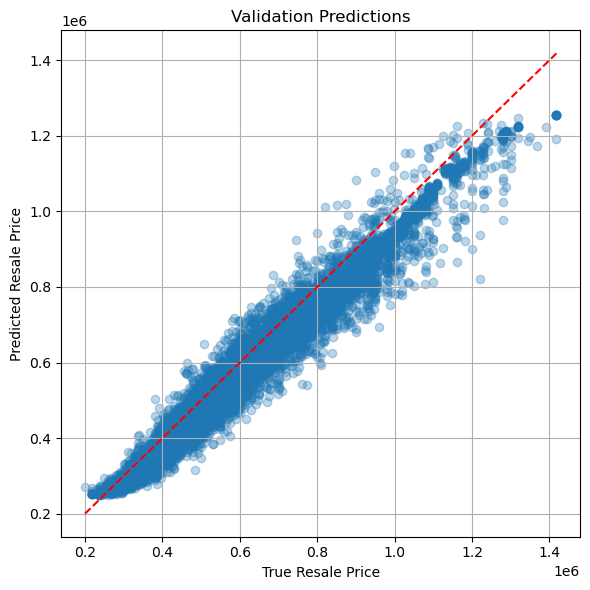

In [ ]:
non_static_dim = 2         # resale_price_normalized + remaining_lease_normalized
static_embedding_dim = 76  # output of your StaticFFModel
hidden_dim = 76            # tunable

encoder = GRUEncoder(
    non_static_dim=non_static_dim,
    static_embedding_dim=static_embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=1
).to(device)

decoder = LSTMDecoder(
    hidden_dim=hidden_dim,
    static_embedding_dim=static_embedding_dim,
    output_dim=1
).to(device)

model = GRUtoLSTM(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

best_val_loss = float('inf')

# Timer 
total_start_time = time.time() 

# Training loop
for epoch in range(10):

    epoch_start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, target_len=1)
    
    # Compute validation-specific normalization stats
    val_resale_mean = df_val['resale_price'].mean()
    val_resale_std = df_val['resale_price'].std()

    val_loss, val_mae, val_r2, val_preds, val_trues = validate_epoch(
        model, val_loader, criterion, device,
        resale_mean=val_resale_mean, resale_std=val_resale_std,
        target_len=1
    )


    epoch_end_time = time.time()  # End timing
    epoch_time = epoch_end_time - epoch_start_time

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | R²: {val_r2:.2f} | Time: {epoch_time:.2f}s")
    
    # Save only if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_gru2lstm_model(model, optimizer, epoch=epoch+1, loss=val_loss, filename="gru2lstm_best.pt")
        print("Best model updated")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")

plot_predictions(val_trues, val_preds)


### Load best model parameters and evaluate on Test Set (GRU2LSTM)

/var/folders/5x/zyxhwl456zgdlj_lrsfyy9qm0000gn/T/ipykernel_69732/2282001578.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map

📂 Loaded model from ./checkpoints/gru2lstm_best.pt (Epoch 3, Val Loss: 0.0261)

📊 Test Results — MAE: 17449.26, R²: 0.98, Loss: 0.0191


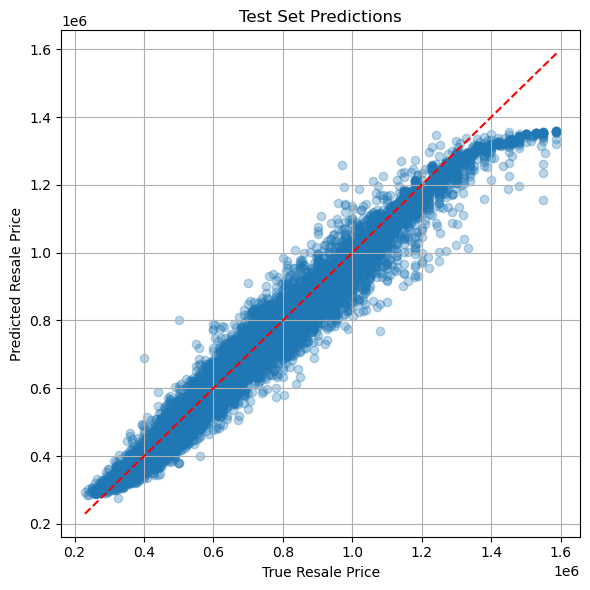

In [202]:
### Load best model parameters and evaluate on Test Set 
# Load the best model after training
model, optimizer, best_epoch, best_loss = load_gru2lstm_model(
    model, optimizer, filename="gru2lstm_best.pt", device=device
)

# Compute test-specific normalization stats
test_resale_mean = df_test['resale_price'].mean()
test_resale_std = df_test['resale_price'].std()

# Run evaluation on the test set
test_loss, test_mae, test_r2, test_preds, test_trues = validate_epoch(
    model, test_loader, criterion, device,
    resale_mean=test_resale_mean,
    resale_std=test_resale_std,
    target_len=1
)

# Print performance metrics
print(f"\n📊 Test Results — MAE: {test_mae:.2f}, R²: {test_r2:.2f}, Loss: {test_loss:.4f}")

# Plot predictions vs ground truth
plot_predictions(test_trues, test_preds, title="Test Set Predictions")


### GRU2LSTM HDB resale flat price prediction

In [203]:
results_df_gru2lstm, top_streets_gru2lstm = recommend_profitable_flats(
    town="TAMPINES",
    budget=500000,
    purchase_year=2017,
    forecast_years=[5, 6, 7],
    df=df_final,
    model=model,
    device=device,
  
)



🏆 Top 10 Profitable Streets:
street_name
TAMPINES ST 24    122292.083333
TAMPINES AVE 8     81555.177083
TAMPINES ST 41     49428.413194
TAMPINES ST 42     46440.173611
TAMPINES AVE 4     37126.772917
TAMPINES AVE 9     31741.984375
TAMPINES ST 82     29258.656250
TAMPINES ST 21     25860.591667
TAMPINES ST 84     25288.083333
SIMEI ST 1         17041.453125
Name: estimated_profit, dtype: float64


# LSTM-to-GRU

### LSTM2GRU Saver and Loader Functions

In [ ]:

def save_lstm2gru_model(model, optimizer, epoch, loss, filename="lstm2gru_best.pt"):
    """
    Saves model and optimizer state into ./checkpoints directory.
    """
    checkpoint_dir = os.path.join('.', 'checkpoints')
    os.makedirs(checkpoint_dir, exist_ok=True)

    save_path = os.path.join(checkpoint_dir, filename)

    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss': loss
    }, save_path)

    print(f"✅ Model checkpoint saved to: {save_path}")

def load_lstm2gru_model(model, optimizer, filename="lstm2gru_best.pt", device="cpu"):
    checkpoint_path = os.path.join('.', 'checkpoints', filename)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    print(f"📂 Loaded model from {checkpoint_path} (Epoch {epoch}, Val Loss: {loss:.4f})")
    return model, optimizer, epoch, loss



### LSTM2GRU Encoder and Decoder

In [205]:
class LSTMtoGRU(nn.Module):
    def __init__(self, encoder: GRUEncoder, decoder: LSTMDecoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x, static_embed, target_len=1, teacher_forcing_inputs=None, teacher_forcing_ratio=0.5):

        hidden = self.encoder(x) # Obtain hidden and cell states from encoder
        hidden = torch.cat(hidden, dim=-1)
        # print(hidden.shape)
        return self.decoder(
            x_encoder=x,
            target_len=target_len,
            static_embed=static_embed,
            hidden=hidden,
            teacher_forcing_inputs=teacher_forcing_inputs,
            teacher_forcing_ratio=teacher_forcing_ratio
        )

### LSTM2GRU Training

Epoch 1 | Train Loss: 0.2653 | Val Loss: 0.0802 | MAE: 46665.42 | R²: 0.92
✅ Model checkpoint saved to: ./checkpoints/lstm2gru_best.pt
Best model updated
Epoch 2 | Train Loss: 0.0343 | Val Loss: 0.0415 | MAE: 28089.79 | R²: 0.96
✅ Model checkpoint saved to: ./checkpoints/lstm2gru_best.pt
Best model updated
Epoch 3 | Train Loss: 0.0338 | Val Loss: 0.0376 | MAE: 26405.57 | R²: 0.96
✅ Model checkpoint saved to: ./checkpoints/lstm2gru_best.pt
Best model updated
Epoch 4 | Train Loss: 0.0296 | Val Loss: 0.0252 | MAE: 18775.43 | R²: 0.98
✅ Model checkpoint saved to: ./checkpoints/lstm2gru_best.pt
Best model updated
Epoch 5 | Train Loss: 0.0283 | Val Loss: 0.0335 | MAE: 24418.63 | R²: 0.97
Epoch 6 | Train Loss: 0.0271 | Val Loss: 0.0450 | MAE: 31544.98 | R²: 0.96
Epoch 7 | Train Loss: 0.0284 | Val Loss: 0.0281 | MAE: 20311.83 | R²: 0.97
Epoch 8 | Train Loss: 0.0261 | Val Loss: 0.0316 | MAE: 26192.22 | R²: 0.97
Epoch 9 | Train Loss: 0.0262 | Val Loss: 0.0345 | MAE: 25012.51 | R²: 0.97
Epoch 10 

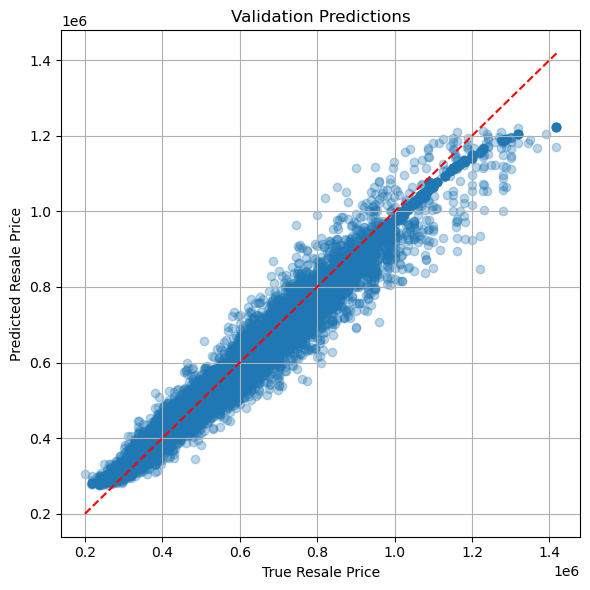

In [ ]:
non_static_dim = 2         # resale_price_normalized + remaining_lease_normalized
static_embedding_dim = 76  # output of your StaticFFModel
hidden_dim = 76            # tunable

encoder = LSTMEncoder(
    non_static_dim=non_static_dim,
    static_embedding_dim=static_embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=1
).to(device)

decoder = GRUDecoder(
    hidden_dim=hidden_dim*2,    # doubled due to hidden & cells state concatenation from LSTM
    static_embedding_dim=static_embedding_dim,
    output_dim=1
).to(device)

model = LSTMtoGRU(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

best_val_loss = float('inf')

# Timer
total_start_time = time.time()

# Training loop
for epoch in range(10):
    epoch_start_time = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, target_len=1)

    # Compute validation-specific normalization stats
    val_resale_mean = df_val['resale_price'].mean()
    val_resale_std = df_val['resale_price'].std()

    val_loss, val_mae, val_r2, val_preds, val_trues = validate_epoch(
        model, val_loader, criterion, device,
        resale_mean=val_resale_mean, resale_std=val_resale_std,
        target_len=1
    )

    epoch_end_time = time.time()  # End timing
    epoch_time = epoch_end_time - epoch_start_time
    # Print epoch results
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | MAE: {val_mae:.2f} | R²: {val_r2:.2f} | Time: {epoch_time:.2f}s")


    # Save only if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_lstm2gru_model(model, optimizer, epoch=epoch+1, loss=val_loss, filename="lstm2gru_best.pt")
        print("Best model updated")

total_end_time = time.time()
total_training_time = total_end_time - total_start_time
print(f"\nTotal Training Time: {total_training_time:.2f} seconds")
plot_predictions(val_trues, val_preds)


### Load best model parameters and evaluate on Test Set (LSTM2GRU)

/var/folders/5x/zyxhwl456zgdlj_lrsfyy9qm0000gn/T/ipykernel_69732/3066638204.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map

📂 Loaded model from ./checkpoints/lstm2gru_best.pt (Epoch 4, Val Loss: 0.0252)

📊 Test Results — MAE: 17774.02, R²: 0.98, Loss: 0.0190


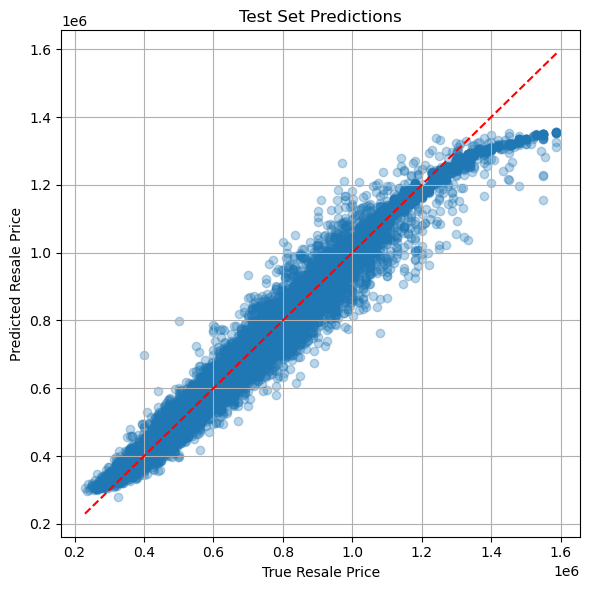

In [208]:
### Load best model parameters and evaluate on Test Set 
# Load the best model after training
model, optimizer, best_epoch, best_loss = load_lstm2gru_model(
    model, optimizer, filename="lstm2gru_best.pt", device=device
)

# Compute test-specific normalization stats
test_resale_mean = df_test['resale_price'].mean()
test_resale_std = df_test['resale_price'].std()

# Run evaluation on the test set
test_loss, test_mae, test_r2, test_preds, test_trues = validate_epoch(
    model, test_loader, criterion, device,
    resale_mean=test_resale_mean,
    resale_std=test_resale_std,
    target_len=1
)

# Print performance metrics
print(f"\n📊 Test Results — MAE: {test_mae:.2f}, R²: {test_r2:.2f}, Loss: {test_loss:.4f}")

# Plot predictions vs ground truth
plot_predictions(test_trues, test_preds, title="Test Set Predictions")


### LSTM2GRU HDB resale flat price prediction

In [209]:
results_df_lstm2gru, top_streets_lstm2gru = recommend_profitable_flats(
    town="TAMPINES",
    budget=500000,
    purchase_year=2017,
    forecast_years=[5, 6, 7],
    df=df_final,
    model=model,
    device=device,
)



🏆 Top 10 Profitable Streets:
street_name
TAMPINES ST 24    102151.041667
TAMPINES AVE 8     86859.656250
TAMPINES ST 42     50717.256944
TAMPINES ST 41     45925.694444
TAMPINES AVE 4     35177.577083
TAMPINES ST 84     29278.156250
TAMPINES AVE 9     27520.645833
TAMPINES ST 21     18164.385417
SIMEI ST 1         18122.036458
TAMPINES ST 22     12486.508681
Name: estimated_profit, dtype: float64
